In [1]:
# Google Colabでの設定
google_colab = True

if google_colab:
    from google.colab import drive
    from google.colab import userdata

    drive.mount("/content/drive")

    # ディレクトリ移動
    %cd /content/drive/MyDrive/Python/kaggle_map/src/ettin-encoder-1b_exp006

Mounted at /content/drive
/content/drive/MyDrive/Python/kaggle_map/src/ettin-encoder-1b_exp006


In [2]:
import os
import gc
import time
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

import torch
import wandb
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

In [3]:
class CFG:
    """実験設定管理クラス"""

    # ============== 実験情報 =============
    comp_name = "kaggle_map"
    exp_name = "ettin-encoder-1b_exp006"
    model_name = "jhu-clsp/ettin-encoder-1b"

    # ============== ファイルパス設定 =============
    comp_dir_path = "../../kaggle/input/"
    comp_dataset_path = f"{comp_dir_path}/map-charting-student-math-misunderstandings/"
    output_dir_path = "output/"
    log_dir_path = "logs/"

    # ============== モデル設定 =============
    max_len = 256

    num_train_epochs = 3
    per_device_train_batch_size = 32
    gradient_accumulation_steps = 1
    per_device_eval_batch_size = 64
    optim_type = "adamw_torch"
    learning_rate = 5e-5
    lr_scheduler_type = "cosine"
    warmup_steps = 50
    weight_decay = 0.01

    # ============== その他設定 =============
    seed = 42
    device = torch.device("cuda")

In [4]:
# 乱数固定
def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

def make_dirs(cfg):
    for dir in [cfg.output_dir_path, cfg.log_dir_path]:
        os.makedirs(dir, exist_ok=True)

def cfg_init(cfg):
    set_seed(cfg.seed)
    make_dirs(cfg)

# 1. LLMの学習

## 1.1 データの読み込み

In [6]:
# データ読み込み
train = pd.read_csv(f"{CFG.comp_dataset_path}/train.csv")
print(train.shape)
train.head(2)

(36696, 7)


,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception
0,0,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),0ne third is equal to tree nineth,True_Correct,NaN
1,1,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 / 3 because 6 over 9 is 2 thirds and 1 third...,True_Correct,NaN


## 1.2 前処理

In [7]:
def add_folds_by_qid_cat_misc(df, n_splits=5, random_state=42, fallback="pair"):
    s_qid = df["QuestionId"].astype(str).fillna("NA")
    s_cat = df["Category"].astype(str).fillna("NA")
    s_misc = df["Misconception"].astype(str).fillna("NA")

    y_triple = s_qid + "|" + s_cat + "|" + s_misc
    y_pair = s_cat + "|" + s_misc

    cnt = y_triple.value_counts()
    if (cnt < n_splits).any():
        if fallback == "pair":
            rare = y_triple.map(cnt) < n_splits
            y = np.where(rare, y_pair, y_triple)
        elif fallback == "category":
            rare = y_triple.map(cnt) < n_splits
            y = np.where(rare, s_cat, y_triple)
        elif fallback == "none":
            y = y_triple
        else:
            raise ValueError("fallback は 'pair' / 'category' / 'none' のいずれかにしてください。")
    else:
        y = y_triple

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    folds = np.full(len(df), -1, dtype=int)
    for fold, (_, val_idx) in enumerate(skf.split(np.zeros(len(df)), y)):
        folds[val_idx] = fold

    out = df.copy()
    out["fold"] = folds
    return out

In [8]:
# fold分割
train = add_folds_by_qid_cat_misc(train, n_splits=5, random_state=42, fallback="pair")
train["fold"].value_counts()

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


,count
fold,
0,7340
1,7339
4,7339
2,7339
3,7339


In [9]:
# 間違っている正解ラベルを修正(MEMO: trainのみに適用しないとCV/LBの相関がとれないが、一旦無視)
false_to_true_ids = [12878, 12901, 13876, 14089, 14159, 14185]
train["Category"] = np.where(train["row_id"].isin(false_to_true_ids), train["Category"].str.replace("False", "True"), train["Category"])

true_to_false_ids = [14280, 14305, 14321, 14335, 14338,  14352, 14355, 14403, 14407, 14412, 14413, 14418]
train["Category"] = np.where(train["row_id"].isin(true_to_false_ids), train["Category"].str.replace("True", "False"), train["Category"])

In [10]:
# 修正されたラベルが含まれるfold
for f in range(5):
    ids = train[(train["fold"] == f) & (train["row_id"].isin(false_to_true_ids) | train["row_id"].isin(true_to_false_ids))]["row_id"].values
    print(f"Fold {f}: {ids}")

Fold 0: [12878 14159]
Fold 1: [14280 14305 14338 14407]
Fold 2: [14089 14335 14355]
Fold 3: [13876 14185 14418]
Fold 4: [12901 14321 14352 14403 14412 14413]


In [11]:
# 重複するMisconceptionを統一(MEMO: 後処理で再分配する必要あり)
train["Misconception"] = train["Misconception"].replace({"Wrong_Fraction": "Wrong_fraction"})

In [12]:
# ラベルの作成
train.Misconception = train.Misconception.fillna("NA")
train["target"] = train.Category + ":" + train.Misconception

# ラベルエンコード
le = LabelEncoder()
train["label"] = le.fit_transform(train["target"])

n_classes = len(le.classes_)
print(f"訓練データの形状: {train.shape} - {n_classes}個のターゲットクラス")
train.head(2)

訓練データの形状: (36696, 10) - 64個のターゲットクラス


,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception,fold,target,label
0,0,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),0ne third is equal to tree nineth,True_Correct,NA,1,True_Correct:NA,36
1,1,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 / 3 because 6 over 9 is 2 thirds and 1 third...,True_Correct,NA,4,True_Correct:NA,36
2,2,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"1 3rd is half of 3 6th, so it is simplee to un...",True_Neither,NA,2,True_Neither:NA,63


## 1.3 特徴量エンジニアリング

In [13]:
# 正解フラグの作成
idx = train.apply(lambda row: row.Category.split("_")[0], axis=1) == "True"
correct = train.loc[idx].copy()
correct["c"] = correct.groupby(["QuestionId", "MC_Answer"]).MC_Answer.transform("count")
correct = correct.sort_values("c", ascending=False)
correct = correct.drop_duplicates(["QuestionId"])
correct = correct[["QuestionId", "MC_Answer"]]
correct["is_correct"] = 1

# 正解ラベルを訓練データにマージ
train = train.merge(correct, on=["QuestionId", "MC_Answer"], how="left")
train.is_correct = train.is_correct.fillna(0)

In [14]:
# 各QuestionIdごとの有効なMisconceptionセットを作成
question_valid_misconceptions = train.groupby("QuestionId")["Misconception"].apply(lambda x: set(x.unique())).to_dict()

# ラベルエンコーダーの逆変換用辞書も作成
label_to_misconception = {}
for i, target in enumerate(le.classes_):
    misconception = target.split(":")[1]
    label_to_misconception[i] = misconception

print(f"問題数: {len(question_valid_misconceptions)}")
print(f"ラベル数: {len(label_to_misconception)}")

問題数: 15
ラベル数: 64

例: QuestionId 31772 の有効なMisconception:
{'NA', 'WNB', 'Incomplete'}


In [21]:
# ラベルからCategoryへのマッピング辞書も作成
label_to_category = {}
for i, target in enumerate(le.classes_):
    category = target.split(':')[0]
    label_to_category[i] = category

## 1.4 tokenize処理

In [22]:
# tokenizerの読み込み
tokenizer = AutoTokenizer.from_pretrained(CFG.model_name)

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

In [23]:
# 学習データのtokenizer処理
def format_input(row):
    x = "Yes"
    if not row["is_correct"]:
        x = "No"
    return (
        f"Question: {row['QuestionText']}\n"
        f"Answer: {row['MC_Answer']}\n"
        f"Correct: {x}\n"
        f"Student Explanation: {row['StudentExplanation']}"
    )

train["text"] = train.apply(format_input, axis=1)
print("LLMへのプロンプト例:")
print()
print(train.text.values[0])

LLMへのプロンプト例:

Question: What fraction of the shape is not shaded? Give your answer in its simplest form. [Image: A triangle split into 9 equal smaller triangles. 6 of them are shaded.]
Answer: \( \frac{1}{3} \)
Correct: Yes
Student Explanation: 0ne third is equal to tree nineth


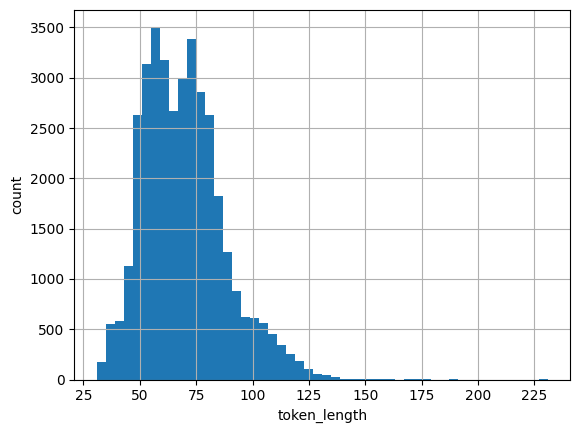

256トークンを超える訓練サンプルが0個あります


array([ 31,  31,  31, ..., 178, 187, 231])

In [24]:
lengths = [len(tokenizer.encode(t, truncation=False)) for t in train["text"]]

# トークン長の分布を可視化
plt.hist(lengths, bins=50)
plt.xlabel("token_length")
plt.ylabel("count")
plt.grid(True)
plt.show()

# max_lenを超えるサンプル数を確認
L = (np.array(lengths) > CFG.max_len).sum()
print(f"{CFG.max_len}トークンを超える訓練サンプルが{L}個あります")
np.sort(lengths)

In [25]:
# 訓練データと検証データに分割
train_df = train[train.fold != 0]
val_df = train[train.fold == 0]

# Hugging Faceデータセットに変換
COLS = ["text", "label"]
train_ds = Dataset.from_pandas(train_df[COLS])
val_ds = Dataset.from_pandas(val_df[COLS])

In [26]:
# トークナイズ関数
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)

train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)

# PyTorch用のフォーマットを設定
columns = ["input_ids", "attention_mask", "label"]
train_ds.set_format(type="torch", columns=columns)
val_ds.set_format(type="torch", columns=columns)

Map:   0%|          | 0/29356 [00:00<?, ? examples/s]

Map:   0%|          | 0/7340 [00:00<?, ? examples/s]

## 1.5 学習設定

In [27]:
# wandbのログイン
wandb.login(key=userdata.get("WANDB_API_KEY"))
wandb.init(project=CFG.comp_name, name=CFG.exp_name)

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: tomokazu_rikioka (tomokazu_rikioka_) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [28]:
# モデルの読み込み
model = AutoModelForSequenceClassification.from_pretrained(
    CFG.model_name,
    num_labels=n_classes,
    reference_compile=False,
)

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/4.13G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.13G [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at jhu-clsp/ettin-encoder-1b and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
# 学習の設定
training_args = TrainingArguments(
    output_dir=CFG.output_dir_path,
    do_train=True,
    do_eval=True,
    eval_strategy="steps",
    save_strategy="steps",
    num_train_epochs=CFG.num_train_epochs,
    per_device_train_batch_size=CFG.per_device_train_batch_size,
    gradient_accumulation_steps=CFG.gradient_accumulation_steps,
    per_device_eval_batch_size=CFG.per_device_eval_batch_size,
    learning_rate=CFG.learning_rate,
    optim=CFG.optim_type,
    lr_scheduler_type=CFG.lr_scheduler_type,
    warmup_steps=CFG.warmup_steps,
    weight_decay=CFG.weight_decay,
    logging_dir=CFG.log_dir_path,
    logging_steps=50,
    save_steps=600,
    eval_steps=300,
    save_total_limit=1,
    metric_for_best_model="map@3",
    greater_is_better=True,
    load_best_model_at_end=True,
    report_to="wandb",
    bf16=True,
    fp16=False,  # KaggleはT4なのでFP16で推論
)

In [30]:
# カスタムメトリック
def compute_map3(eval_pred):
    logits, labels = eval_pred
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()

    top3 = np.argsort(-probs, axis=1)[:, :3]  # トップ3の予測
    match = top3 == labels[:, None]

    # MAP@3を計算
    map3 = 0
    for i in range(len(labels)):
        if match[i, 0]:
            map3 += 1.0
        elif match[i, 1]:
            map3 += 1.0 / 2
        elif match[i, 2]:
            map3 += 1.0 / 3
    return {"map@3": map3 / len(labels)}

## 1.6 モデルの学習

In [31]:
# トレーナーの設定
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    processing_class=tokenizer,
    compute_metrics=compute_map3,
)

# モデルの学習
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': None, 'bos_token_id': None}.


Step,Training Loss,Validation Loss,Map@3
300,0.519800,0.502324,0.904927
600,0.510900,0.403072,0.926885
900,0.399100,0.386274,0.925159
1200,0.285400,0.387827,0.928202
1500,0.278200,0.335327,0.938238
1800,0.297700,0.313815,0.940123
2100,0.126100,0.370666,0.941190
2400,0.120900,0.387434,0.940895
2700,0.101300,0.382034,0.941689


TrainOutput(global_step=2754, training_loss=0.3305956387030706, metrics={'train_runtime': 1688.9361, 'train_samples_per_second': 52.144, 'train_steps_per_second': 1.631, 'total_flos': 1.2730747640020992e+17, 'train_loss': 0.3305956387030706, 'epoch': 3.0})

## 1.7 モデルの保存

In [32]:
trainer.save_model(f"{CFG.output_dir_path}/model")
tokenizer.save_pretrained(f"{CFG.output_dir_path}/tokenizer")

('output//tokenizer/tokenizer_config.json',
 'output//tokenizer/special_tokens_map.json',
 'output//tokenizer/tokenizer.json')

In [33]:
# WandBのセッションを終了
with wandb.init():
    wandb.finish()

eval/loss,█▄▄▄▂▁▃▄▄
eval/map@3,▁▅▅▅▇████
eval/runtime,▂▁█▄▃▄▇▆▄
eval/samples_per_second,▇█▁▅▆▅▂▃▅
eval/steps_per_second,▇█▁▅▆▅▃▃▅
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇██
train/grad_norm,█▅▆▆▅▄▅▆▄▆▂▃▃▄▄▂▂▃▃▄▂▃▃▃▂▃▃▂▂▂▂▂▁▂▂▂▂▁▂▃
train/learning_rate,███████▇▇▇▇▇▇▆▆▆▆▆▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁
train/loss,█▄▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/loss,0.38203


In [34]:
# キャッシュ削除
del model, tokenizer, trainer
gc.collect()
torch.cuda.empty_cache()

# 2. 結果分析

## 2.1 検証データの予測

In [35]:
# 学習済みモデルの読み込み
model_path = f"{CFG.output_dir_path}/model"
tokenizer_path = f"{CFG.output_dir_path}/tokenizer"

inference_model = AutoModelForSequenceClassification.from_pretrained(
    model_path,
    num_labels=n_classes,
    reference_compile=False,
)
inference_tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

# 推論用のインスタンスを作成
inference_trainer = Trainer(
    model=inference_model,
    processing_class=inference_tokenizer
)

# 検証データの推論実行
inference_model.eval()
start_time = time.time()

val_predictions = inference_trainer.predict(val_ds)
logits = val_predictions.predictions
val_labels = val_predictions.label_ids

# 推論時間を計算
inference_time = time.time() - start_time
print(f"推論時間: {inference_time:.2f}秒")
print(f"サンプル数: {len(val_labels)}個")
print(f"1サンプルあたりの推論時間: {inference_time/len(val_labels)*1000:.2f}ms")

# 確率値に変換
val_probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()

# Top-1精度の計算
val_pred_labels = np.argmax(logits, axis=1)
accuracy = (val_pred_labels == val_labels).mean()
print(f"\nTop-1精度: {accuracy:.4f}")

# MAP@3スコアの計算
map3_score = compute_map3((logits, val_labels))["map@3"]
print(f"MAP@3スコア: {map3_score:.4f}")

推論時間: 42.85秒
サンプル数: 7340個
1サンプルあたりの推論時間: 5.84ms

Top-1精度: 0.8868
MAP@3スコア: 0.9402


## 2.2 後処理

In [36]:
def apply_misconception_mask(logits, question_ids, question_valid_misconceptions, label_to_misconception):
    """各問題で選択可能なMisconceptionのみを残すマスキング"""
    masked_logits = logits.copy()

    for i, qid in enumerate(question_ids):
        valid_misconceptions = question_valid_misconceptions.get(qid, None)

        if valid_misconceptions is None:
            # 訓練データに存在しないQuestionIdの場合はマスクしない
            continue

        # 各ラベルをチェックして、無効なMisconceptionを含むものをマスク
        for label_idx in range(logits.shape[1]):
            misconception = label_to_misconception[label_idx]
            if misconception not in valid_misconceptions:
                masked_logits[i, label_idx] = -np.inf

    return masked_logits

In [37]:
def apply_category_mask(logits, is_correct_flags, label_to_category, mode="exclude"):
    """正解/不正解に基づいてTrue/Falseカテゴリをマスキング"""
    masked_logits = logits.copy()

    if mode == "exclude":
        # 除外モード：不適切なカテゴリを-infにする
        for i, is_correct in enumerate(is_correct_flags):
            for label_idx in range(logits.shape[1]):
                category = label_to_category[label_idx]

                if is_correct == 1:
                    # 正解の場合、True_*以外を除外
                    if not category.startswith("True_"):
                        masked_logits[i, label_idx] = -np.inf
                else:
                    # 不正解の場合、False_*以外を除外
                    if not category.startswith("False_"):
                        masked_logits[i, label_idx] = -np.inf

    elif mode == "flip":
        # 反転モード：不適切なカテゴリの確率を適切なカテゴリに転送
        for i, is_correct in enumerate(is_correct_flags):
            # カテゴリごとにロジットを集計
            true_indices = []
            false_indices = []

            for label_idx in range(logits.shape[1]):
                category = label_to_category[label_idx]
                if category.startswith("True_"):
                    true_indices.append(label_idx)
                elif category.startswith("False_"):
                    false_indices.append(label_idx)

            if is_correct == 1:
                # 正解の場合、False_*のロジットをTrue_*の対応するものに転送
                for false_idx in false_indices:
                    false_cat = label_to_category[false_idx]
                    false_suffix = false_cat[6:]  # "False_"の後の部分

                    # 対応するTrue_*を探す
                    for true_idx in true_indices:
                        true_cat = label_to_category[true_idx]
                        if true_cat == f"True_{false_suffix}":
                            # ロジットを加算（log空間での確率の加算）
                            masked_logits[i, true_idx] = np.logaddexp(
                                masked_logits[i, true_idx],
                                masked_logits[i, false_idx]
                            )
                            masked_logits[i, false_idx] = -np.inf
                            break
            else:
                # 不正解の場合、True_*のロジットをFalse_*の対応するものに転送
                for true_idx in true_indices:
                    true_cat = label_to_category[true_idx]
                    true_suffix = true_cat[5:]  # "True_"の後の部分

                    # 対応するFalse_*を探す
                    for false_idx in false_indices:
                        false_cat = label_to_category[false_idx]
                        if false_cat == f"False_{true_suffix}":
                            # ロジットを加算（log空間での確率の加算）
                            masked_logits[i, false_idx] = np.logaddexp(
                                masked_logits[i, false_idx],
                                masked_logits[i, true_idx]
                            )
                            masked_logits[i, true_idx] = -np.inf
                            break

    return masked_logits

In [38]:
def apply_combined_mask(logits, question_ids, is_correct_flags,
                        question_valid_misconceptions, label_to_misconception,
                        label_to_category, category_mode='exclude'):
    """
    MisconceptionとCategoryの両方のマスキングを適用

    Parameters:
    -----------
    logits : numpy.ndarray
        予測ロジット
    question_ids : array-like
        各サンプルのQuestionId
    is_correct_flags : array-like
        各サンプルが正解かどうか
    question_valid_misconceptions : dict
        QuestionIdごとの有効なMisconceptionセット
    label_to_misconception : dict
        ラベルからMisconceptionへのマッピング
    label_to_category : dict
        ラベルからCategoryへのマッピング
    category_mode : str
        'exclude' or 'flip'

    Returns:
    --------
    numpy.ndarray
        マスク適用後のロジット
    """
    # まずMisconceptionマスクを適用
    masked_logits = apply_misconception_mask(
        logits, question_ids, question_valid_misconceptions, label_to_misconception
    )

    # 次にCategoryマスクを適用
    masked_logits = apply_category_mask(
        masked_logits, is_correct_flags, label_to_category, mode=category_mode
    )

    return masked_logits

In [39]:
# マスキング処理の比較
print("=" * 60)
print("各種マスキング手法の比較")
print("=" * 60)

# 検証データのQuestionIdとis_correctフラグを取得
val_question_ids = val_df['QuestionId'].values
val_is_correct = val_df['is_correct'].values

# オリジナル（マスクなし）
map3_original = compute_map3((logits, val_labels))["map@3"]
accuracy_original = (np.argmax(logits, axis=1) == val_labels).mean()
print(f"\n1. マスクなし:")
print(f"   MAP@3: {map3_original:.4f}")
print(f"   Top-1精度: {accuracy_original:.4f}")

# Misconceptionマスクのみ
masked_logits_misc = apply_misconception_mask(
    logits, val_question_ids, question_valid_misconceptions, label_to_misconception
)
map3_misc = compute_map3((masked_logits_misc, val_labels))["map@3"]
accuracy_misc = (np.argmax(masked_logits_misc, axis=1) == val_labels).mean()
print(f"\n2. Misconceptionマスクのみ:")
print(f"   MAP@3: {map3_misc:.4f} ({(map3_misc - map3_original)*100:+.2f}%)")
print(f"   Top-1精度: {accuracy_misc:.4f} ({(accuracy_misc - accuracy_original)*100:+.2f}%)")

# Categoryマスク（除外モード）のみ
masked_logits_cat_exclude = apply_category_mask(
    logits, val_is_correct, label_to_category, mode='exclude'
)
map3_cat_exclude = compute_map3((masked_logits_cat_exclude, val_labels))["map@3"]
accuracy_cat_exclude = (np.argmax(masked_logits_cat_exclude, axis=1) == val_labels).mean()
print(f"\n3. Categoryマスク（除外モード）のみ:")
print(f"   MAP@3: {map3_cat_exclude:.4f} ({(map3_cat_exclude - map3_original)*100:+.2f}%)")
print(f"   Top-1精度: {accuracy_cat_exclude:.4f} ({(accuracy_cat_exclude - accuracy_original)*100:+.2f}%)")

# Categoryマスク（反転モード）のみ
masked_logits_cat_flip = apply_category_mask(
    logits, val_is_correct, label_to_category, mode='flip'
)
map3_cat_flip = compute_map3((masked_logits_cat_flip, val_labels))["map@3"]
accuracy_cat_flip = (np.argmax(masked_logits_cat_flip, axis=1) == val_labels).mean()
print(f"\n4. Categoryマスク（反転モード）のみ:")
print(f"   MAP@3: {map3_cat_flip:.4f} ({(map3_cat_flip - map3_original)*100:+.2f}%)")
print(f"   Top-1精度: {accuracy_cat_flip:.4f} ({(accuracy_cat_flip - accuracy_original)*100:+.2f}%)")

# 組み合わせ（Misconception + Category除外）
masked_logits_combined_exclude = apply_combined_mask(
    logits, val_question_ids, val_is_correct,
    question_valid_misconceptions, label_to_misconception,
    label_to_category, category_mode='exclude'
)
map3_combined_exclude = compute_map3((masked_logits_combined_exclude, val_labels))["map@3"]
accuracy_combined_exclude = (np.argmax(masked_logits_combined_exclude, axis=1) == val_labels).mean()
print(f"\n5. Misconception + Category（除外）:")
print(f"   MAP@3: {map3_combined_exclude:.4f} ({(map3_combined_exclude - map3_original)*100:+.2f}%)")
print(f"   Top-1精度: {accuracy_combined_exclude:.4f} ({(accuracy_combined_exclude - accuracy_original)*100:+.2f}%)")

# 組み合わせ（Misconception + Category反転）
masked_logits_combined_flip = apply_combined_mask(
    logits, val_question_ids, val_is_correct,
    question_valid_misconceptions, label_to_misconception,
    label_to_category, category_mode='flip'
)
map3_combined_flip = compute_map3((masked_logits_combined_flip, val_labels))["map@3"]
accuracy_combined_flip = (np.argmax(masked_logits_combined_flip, axis=1) == val_labels).mean()
print(f"\n6. Misconception + Category（反転）:")
print(f"   MAP@3: {map3_combined_flip:.4f} ({(map3_combined_flip - map3_original)*100:+.2f}%)")
print(f"   Top-1精度: {accuracy_combined_flip:.4f} ({(accuracy_combined_flip - accuracy_original)*100:+.2f}%)")

# 最良の手法を選択
print("\n" + "=" * 60)
best_method = max([
    ("マスクなし", map3_original),
    ("Misconceptionマスクのみ", map3_misc),
    ("Categoryマスク（除外）のみ", map3_cat_exclude),
    ("Categoryマスク（反転）のみ", map3_cat_flip),
    ("Misconception + Category（除外）", map3_combined_exclude),
    ("Misconception + Category（反転）", map3_combined_flip)
], key=lambda x: x[1])

print(f"最良の手法: {best_method[0]} (MAP@3: {best_method[1]:.4f})")

# 最良の手法のlogitsを使用して以降の分析を行う
if best_method[0] == "Misconception + Category（除外）":
    logits = masked_logits_combined_exclude
elif best_method[0] == "Misconception + Category（反転）":
    logits = masked_logits_combined_flip
elif best_method[0] == "Misconceptionマスクのみ":
    logits = masked_logits_misc
elif best_method[0] == "Categoryマスク（除外）のみ":
    logits = masked_logits_cat_exclude
elif best_method[0] == "Categoryマスク（反転）のみ":
    logits = masked_logits_cat_flip
# else: オリジナルのlogitsを使用

val_probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()
val_pred_labels = np.argmax(logits, axis=1)
accuracy = (val_pred_labels == val_labels).mean()
map3_score = compute_map3((logits, val_labels))["map@3"]

print(f"\n選択した手法での最終スコア:")
print(f"MAP@3: {map3_score:.4f}")
print(f"Top-1精度: {accuracy:.4f}")

各種マスキング手法の比較

1. マスクなし:
   MAP@3: 0.9402
   Top-1精度: 0.8868

2. Misconceptionマスクのみ:
   MAP@3: 0.9404 (+0.02%)
   Top-1精度: 0.8868 (+0.00%)

3. Categoryマスク（除外モード）のみ:
   MAP@3: 0.9405 (+0.03%)
   Top-1精度: 0.8868 (+0.00%)

4. Categoryマスク（反転モード）のみ:
   MAP@3: 0.9401 (-0.01%)
   Top-1精度: 0.8862 (-0.05%)

5. Misconception + Category（除外）:
   MAP@3: 0.9407 (+0.05%)
   Top-1精度: 0.8868 (+0.00%)

6. Misconception + Category（反転）:
   MAP@3: 0.9405 (+0.03%)
   Top-1精度: 0.8862 (-0.05%)

最良の手法: Misconception + Category（除外） (MAP@3: 0.9407)

選択した手法での最終スコア:
MAP@3: 0.9407
Top-1精度: 0.8868


## 項目別の結果分析

In [ ]:
# Top-3予測の取得
top3_indices = np.argsort(-val_probs, axis=1)[:, :3]
top3_probs = np.take_along_axis(val_probs, top3_indices, axis=1)

# Top-1予測の取得
max_probs = val_probs.max(axis=1)

In [ ]:
# 検証データに必要な情報を追加
val_df_analysis = val_df.copy()
val_df_analysis["pred_label"] = val_pred_labels
val_df_analysis["actual_label"] = val_labels
val_df_analysis["confidence"] = max_probs
val_df_analysis["is_correct"] = (val_pred_labels == val_labels)

# Top-3予測の情報を追加（MAP@3評価用）
for i in range(3):
    val_df_analysis[f"top{i+1}_label"] = top3_indices[:, i]
    val_df_analysis[f"top{i+1}_prob"] = top3_probs[:, i]
    val_df_analysis[f"top{i+1}_name"] = [le.inverse_transform([x])[0] for x in top3_indices[:, i]]

# Top-5予測の情報も追加（出力用）
top5_indices = np.argsort(-val_probs, axis=1)[:, :5]
top5_probs = np.take_along_axis(val_probs, top5_indices, axis=1)
for i in range(3, 5):
    val_df_analysis[f"top{i+1}_label"] = top5_indices[:, i]
    val_df_analysis[f"top{i+1}_prob"] = top5_probs[:, i]
    val_df_analysis[f"top{i+1}_name"] = [le.inverse_transform([x])[0] for x in top5_indices[:, i]]

# Top-3に正解が含まれているか
val_df_analysis["is_in_top3"] = [label in top3_indices[i] for i, label in enumerate(val_labels)]

# Top-5に正解が含まれているか
val_df_analysis["is_in_top5"] = [label in top5_indices[i] for i, label in enumerate(val_labels)]

# MAP@3スコアを各サンプルごとに計算
def calculate_map3_per_sample(row):
    if row["actual_label"] == row["top1_label"]:
        return 1.0
    elif row["actual_label"] == row["top2_label"]:
        return 1.0 / 2
    elif row["actual_label"] == row["top3_label"]:
        return 1.0 / 3
    else:
        return 0.0

val_df_analysis["map3_score"] = val_df_analysis.apply(calculate_map3_per_sample, axis=1)

# CategoryとMisconceptionを分離
val_df_analysis["actual_category"] = val_df_analysis["target"].apply(lambda x: x.split(":")[0])
val_df_analysis["actual_misconception"] = val_df_analysis["target"].apply(lambda x: x.split(":")[1])
val_df_analysis["pred_category"] = val_df_analysis["top1_name"].apply(lambda x: x.split(":")[0])
val_df_analysis["pred_misconception"] = val_df_analysis["top1_name"].apply(lambda x: x.split(":")[1])

### Questionごとの予測確率分布

In [ ]:
question_stats = val_df_analysis.groupby("QuestionId").agg({
    "map3_score": "mean",
    "is_correct": "mean",
    "is_in_top3": "mean",
    "confidence": "mean",
    "QuestionText": "first",
    "label": "count"
}).rename(columns={
    "map3_score": "MAP@3",
    "is_correct": "Top1_Accuracy",
    "is_in_top3": "Top3_Accuracy",
    "confidence": "Avg_Confidence",
    "label": "Sample_Count"
}).sort_values("MAP@3", ascending=False)

# 結果の表示
question_stats = question_stats.reset_index()
question_stats

,QuestionId,MAP@3,Top1_Accuracy,Top3_Accuracy,Avg_Confidence,QuestionText,Sample_Count
0,32829,0.966744,0.935035,1.000000,0.978361,\( 2 y=24 \) What is the value of \( y \) ?,431
1,31777,0.963523,0.928826,0.998221,0.979414,A box contains \( 120 \) counters. The counter...,562
2,31772,0.959191,0.916667,1.000000,0.949563,What fraction of the shape is not shaded? Give...,972
3,109465,0.949206,0.900000,1.000000,0.959142,The probability of an event occurring is \( 0....,210
4,33471,0.947141,0.902913,0.996764,0.971227,A bag contains \( 24 \) yellow and green balls...,309
5,76870,0.940928,0.881857,1.000000,0.969139,This is part of a regular polygon. How many si...,237
6,33472,0.939286,0.883929,0.996429,0.951779,\( \frac{1}{3}+\frac{2}{5}= \),560
7,89443,0.939171,0.888707,0.993453,0.955272,What number belongs in the box?\n\(\n(-8)-(-5)...,611
8,91695,0.933589,0.875479,0.994253,0.955676,Dots have been arranged in these patterns: [Im...,522
9,32833,0.932904,0.867955,0.996779,0.951234,Calculate \( \frac{2}{3} \times 5 \),621


### Categoryごとの予測確率分布

In [ ]:
category_stats = val_df_analysis.groupby("actual_category").agg({
    "map3_score": "mean",
    "is_correct": "mean",
    "is_in_top3": "mean",
    "confidence": "mean",
    "label": "count"
}).rename(columns={
    "map3_score": "MAP@3",
    "is_correct": "Top1_Accuracy",
    "is_in_top3": "Top3_Accuracy",
    "confidence": "Avg_Confidence",
    "label": "Sample_Count"
}).sort_values("MAP@3", ascending=False)

# 結果の表示
category_stats = category_stats.reset_index()
category_stats

,actual_category,MAP@3,Top1_Accuracy,Top3_Accuracy,Avg_Confidence,Sample_Count
0,True_Correct,0.973978,0.950659,0.998986,0.974249,2959
1,False_Misconception,0.946998,0.902272,0.996302,0.960887,1893
2,False_Neither,0.921899,0.845329,0.999234,0.946749,1306
3,True_Neither,0.882418,0.762311,0.999053,0.917653,1056
4,False_Correct,0.779070,0.651163,0.930233,0.917423,43
5,True_Misconception,0.704819,0.566265,0.891566,0.843536,83


### Misconceptionごとの予測確率分布

In [ ]:
misconception_stats = val_df_analysis.groupby("actual_misconception").agg({
    "map3_score": "mean",
    "is_correct": "mean",
    "is_in_top3": "mean",
    "confidence": "mean",
    "label": "count"
}).rename(columns={
    "map3_score": "MAP@3",
    "is_correct": "Top1_Accuracy",
    "is_in_top3": "Top3_Accuracy",
    "confidence": "Avg_Confidence",
    "label": "Sample_Count"
}).sort_values("MAP@3", ascending=False)

# 結果の表示
misconception_stats = misconception_stats.reset_index()
display(misconception_stats.head())
display(misconception_stats.tail())

,actual_misconception,MAP@3,Top1_Accuracy,Top3_Accuracy,Avg_Confidence,Sample_Count
0,Interior,1.000000,1.000000,1.000000,0.999636,10
1,Additive,0.975936,0.957219,0.994652,0.979665,187
2,Denominator-only_change,0.974747,0.954545,1.000000,0.973324,66
3,Duplication,0.968085,0.936170,1.000000,0.971152,141
4,Inversion,0.961847,0.927711,1.000000,0.957914,83


,actual_misconception,MAP@3,Top1_Accuracy,Top3_Accuracy,Avg_Confidence,Sample_Count
30,Base_rate,0.750000,0.666667,0.833333,0.918591,6
31,Certainty,0.666667,0.333333,1.000000,0.723223,3
32,Incorrect_equivalent_fraction_addition,0.500000,0.500000,0.500000,0.826544,2
33,Wrong_Operation,0.500000,0.000000,1.000000,0.486240,1
34,Shorter_is_bigger,0.291667,0.000000,0.750000,0.909086,4


### ラベル（Category:Misconception）ごとの予測確率分布

In [ ]:
label_level_stats = val_df_analysis.groupby("target").agg({
    "map3_score": "mean",
    "is_correct": "mean",
    "is_in_top3": "mean",
    "confidence": "mean",
    "top1_prob": "mean",
    "top2_prob": "mean",
    "top3_prob": "mean",
    "label": "count"
}).rename(columns={
    "map3_score": "MAP@3",
    "is_correct": "Top1_Accuracy",
    "is_in_top3": "Top3_Accuracy",
    "confidence": "Avg_Confidence",
    "top1_prob": "Avg_Top1_Prob",
    "top2_prob": "Avg_Top2_Prob",
    "top3_prob": "Avg_Top3_Prob",
    "label": "Sample_Count"
}).sort_values('MAP@3', ascending=False)

# 結果を表示
label_level_stats = label_level_stats.reset_index()
display(label_level_stats.head())
display(label_level_stats.tail())

,target,MAP@3,Top1_Accuracy,Top3_Accuracy,Avg_Confidence,Avg_Top1_Prob,Avg_Top2_Prob,Avg_Top3_Prob,Sample_Count
0,False_Misconception:Incorrect_equivalent_fract...,1.000000,1.000000,1.000000,0.804040,0.804040,0.131256,0.048286,1
1,False_Misconception:Interior,1.000000,1.000000,1.000000,0.999636,0.999636,0.000305,0.000047,10
2,True_Misconception:Duplication,1.000000,1.000000,1.000000,0.432640,0.432640,0.316526,0.191983,1
3,False_Misconception:Additive,0.986034,0.977654,0.994413,0.989641,0.989641,0.010064,0.000186,179
4,False_Misconception:Denominator-only_change,0.974747,0.954545,1.000000,0.973324,0.973324,0.024842,0.001380,66


,target,MAP@3,Top1_Accuracy,Top3_Accuracy,Avg_Confidence,Avg_Top1_Prob,Avg_Top2_Prob,Avg_Top3_Prob,Sample_Count
54,True_Misconception:Incorrect_equivalent_fracti...,0.0,0.0,0.0,0.849047,0.849047,0.111371,0.016554,1
55,True_Misconception:Positive,0.0,0.0,0.0,0.998137,0.998137,0.001098,0.000269,1
56,True_Misconception:Subtraction,0.0,0.0,0.0,0.954626,0.954626,0.021090,0.009359,1
57,True_Misconception:Whole_numbers_larger,0.0,0.0,0.0,0.998254,0.998254,0.000626,0.000286,1
58,True_Misconception:Wrong_term,0.0,0.0,0.0,0.984623,0.984623,0.011901,0.001298,2


In [ ]:
# CSVで保存
question_stats.to_csv(f"{CFG.output_dir_path}/question_statistics.csv")
category_stats.to_csv(f"{CFG.output_dir_path}/category_statistics.csv")
misconception_stats.to_csv(f"{CFG.output_dir_path}/misconception_statistics.csv")
label_level_stats.to_csv(f"{CFG.output_dir_path}/label_level_statistics.csv")

In [ ]:
# 検証データの全レコードに予測結果を付与したデータフレームを保存
val_df_with_predictions = val_df_analysis[[
    "row_id", "QuestionId", "QuestionText", "MC_Answer", "StudentExplanation",
    "Category", "Misconception", "target", "label", "actual_label",
    "pred_label", "confidence", "is_correct", "is_in_top3", "is_in_top5", "map3_score",
    "top1_label", "top1_prob", "top1_name",
    "top2_label", "top2_prob", "top2_name",
    "top3_label", "top3_prob", "top3_name",
    "top4_label", "top4_prob", "top4_name",
    "top5_label", "top5_prob", "top5_name",
    "actual_category", "actual_misconception",
    "pred_category", "pred_misconception"
]]

val_df_with_predictions.to_csv(f"{CFG.output_dir_path}/val_predictions_full.csv", index=False)